In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [3]:
# --- RBM Class ---
class RBM(tf.Module):
    def __init__(self, n_visible, n_hidden, name=None):
        super().__init__(name=name)
        self.n_visible = n_visible
        self.n_hidden = n_hidden

        # Weight and biases initialization
        self.W = tf.Variable(tf.random.normal([n_visible, n_hidden], stddev=0.01))
        self.h_bias = tf.Variable(tf.zeros([n_hidden]))
        self.v_bias = tf.Variable(tf.zeros([n_visible]))

    def sample_prob(self, probs):
        return tf.cast(tf.random.uniform(tf.shape(probs)) < probs, tf.float32)

    def v_to_h(self, v):
        h_prob = tf.nn.sigmoid(tf.matmul(v, self.W) + self.h_bias)
        return h_prob, self.sample_prob(h_prob)

    def h_to_v(self, h):
        v_prob = tf.nn.sigmoid(tf.matmul(h, tf.transpose(self.W)) + self.v_bias)
        return v_prob, self.sample_prob(v_prob)

    def contrastive_divergence(self, v0, lr=0.01):
        h0_prob, h0_sample = self.v_to_h(v0)
        v1_prob, v1_sample = self.h_to_v(h0_sample)
        h1_prob, _ = self.v_to_h(v1_sample)

        # Weight and bias updates
        W_update = tf.matmul(tf.transpose(v0), h0_prob) - tf.matmul(tf.transpose(v1_sample), h1_prob)
        self.W.assign_add(lr * W_update / tf.cast(tf.shape(v0)[0], tf.float32))
        self.v_bias.assign_add(lr * tf.reduce_mean(v0 - v1_sample, axis=0))
        self.h_bias.assign_add(lr * tf.reduce_mean(h0_prob - h1_prob, axis=0))

        loss = tf.reduce_mean(tf.square(v0 - v1_prob))
        return loss

    def forward(self, v):
        h_prob, _ = self.v_to_h(v)
        return h_prob


In [4]:
# --- Data Preprocessing ---
def preprocess(x):
    x = x.astype(np.float32) / 255.
    return x.reshape(-1, 784)


In [5]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = preprocess(x_train)
x_test = preprocess(x_test)


In [6]:
# --- Training Function ---
def train_rbm(rbm, data, epochs=5, batch_size=64, lr=0.01):
    for epoch in range(epochs):
        losses = []
        for i in range(0, len(data), batch_size):
            batch = tf.convert_to_tensor(data[i:i+batch_size])
            loss = rbm.contrastive_divergence(batch, lr)
            losses.append(loss.numpy())
        print(f"RBM {rbm.n_visible}->{rbm.n_hidden} | Epoch {epoch+1}, Loss: {np.mean(losses):.4f}")


In [7]:
# --- Gibbs Sampling ---
def gibbs_sampling(rbm, steps=100, v_init=None):
    if v_init is None:
        v = tf.cast(tf.random.uniform((1, rbm.n_visible)) < 0.5, tf.float32)
    else:
        v = tf.identity(v_init)

    for _ in range(steps):
        h_prob, h_sample = rbm.v_to_h(v)
        v_prob, v_sample = rbm.h_to_v(h_sample)
        v = v_sample
    return v


In [8]:
# --- Visualize Sample ---
def show_sample(sample):
    plt.imshow(sample.numpy().reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.show()

In [15]:
# --- Create RBM ---
rbm = RBM(784, 256)

In [40]:
#  --- Train RBM ---
train_rbm(rbm, x_train, epochs=5)

RBM 784->256 | Epoch 1, Loss: 0.0184
RBM 784->256 | Epoch 2, Loss: 0.0178
RBM 784->256 | Epoch 3, Loss: 0.0174
RBM 784->256 | Epoch 4, Loss: 0.0169
RBM 784->256 | Epoch 5, Loss: 0.0165


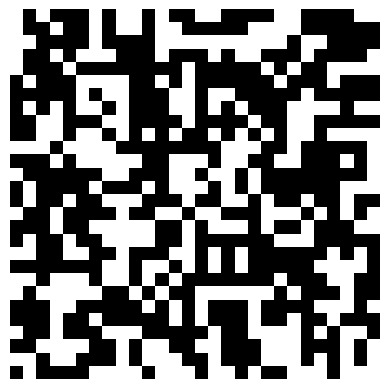

In [ ]:
# --- Generate and Show Image ---
sample = gibbs_sampling(rbm, steps=100)
show_sample(sample)
